In [1]:
import time
import torch
from torch import nn, optim

import sys
sys.path.append("..") 
from d2l import torch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def vgg_block(num_convs, in_channels, out_channels):
    blk = []
    for i in range(num_convs):
        if i == 0:
            blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        else:
            blk.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.ReLU())
    blk.append(nn.MaxPool2d(kernel_size=2, stride=2)) # 这里会使宽高减半
    return nn.Sequential(*blk)

In [13]:
conv_arch=((1,1,64),(1,64,128),(2,128,256),(2,256,512),(2,512,512))
fc_features = 512 * 7 * 7 # c * w * h
fc_hidden_units = 4096 # 任意

In [14]:
def vgg(conv_arch, fc_features, fc_hidden_units=4096):
    net = nn.Sequential()
    # 卷积层部分
    for i, (num_convs, in_channels, out_channels) in enumerate(conv_arch):
        # 每经过一个vgg_block都会使宽高减半
        net.add_module("vgg_block_" + str(i+1), vgg_block(num_convs, in_channels, out_channels))
    # 全连接层部分
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                 nn.Linear(fc_features, fc_hidden_units),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(fc_hidden_units, fc_hidden_units),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(fc_hidden_units, 10)
                                ))
    return net

In [15]:
net = vgg(conv_arch, fc_features, fc_hidden_units)
X = torch.rand(1, 1, 224, 224)

# named_children获取一级子模块及其名字(named_modules会返回所有子模块,包括子模块的子模块)
for name, blk in net.named_children(): 
    X = blk(X)
    print(name, 'output shape: ', X.shape)

vgg_block_1 output shape:  torch.Size([1, 64, 112, 112])
vgg_block_2 output shape:  torch.Size([1, 128, 56, 56])
vgg_block_3 output shape:  torch.Size([1, 256, 28, 28])
vgg_block_4 output shape:  torch.Size([1, 512, 14, 14])
vgg_block_5 output shape:  torch.Size([1, 512, 7, 7])
fc output shape:  torch.Size([1, 10])


In [16]:
ratio = 8
small_conv_arch = [(1, 1, 64//ratio), (1, 64//ratio, 128//ratio), (2, 128//ratio, 256//ratio), 
                   (2, 256//ratio, 512//ratio), (2, 512//ratio, 512//ratio)]
net = vgg(small_conv_arch, fc_features // ratio, fc_hidden_units // ratio)
print(net)

Sequential(
  (vgg_block_1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

loss 0.899, train acc 0.667, test acc 0.736
131.1 examples/sec on cpu


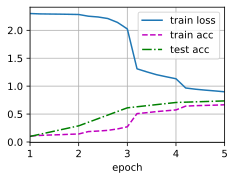

In [19]:
batch_size = 64
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch6(net, train_iter, test_iter,  num_epochs,lr,device)